## [기준 정의]

- 시즌: 2025 정규시즌
- 대상 경기: 정규시즌 전체 (포스트시즌 제외)
- 집계 단위: 팀 단위 (선수 → 팀 집계 후 계산)
- ERA: (팀 자책점 / 팀 이닝) * 9
- FIP: Statiz 제공 FIP 사용 (재계산 ❌)
- 이닝 기준: 소수 이닝 그대로 사용 (1/3, 2/3 포함)


In [2]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"   # macOS 한글 폰트
plt.rcParams["axes.unicode_minus"] = False    # 마이너스 깨짐 방지

Teams (2025): ['KIA', 'KT', 'LG', 'NC', 'SSG', '두산', '롯데', '삼성', '키움', '한화']
N teams: 10
Rows: 137
Team  IP_sum  ER_sum  ERA_team_calc  FIP_team_wavg  ERA_player_mean  FIP_player_mean
  한화  1216.5     464       3.432799       3.507041         3.646429         3.836429
 SSG  1176.5     459       3.511262       3.873896         3.600000         4.075714
  LG  1113.8     438       3.539235       3.818965         3.735714         4.025714
  KT  1125.5     476       3.806308       3.883075         3.808462         4.030000
  삼성  1139.6     501       3.956651       4.257820         4.153571         4.268571
  두산  1049.3     470       4.031259       4.244571         4.176667         4.308333
 KIA  1092.0     520       4.285714       4.116965         4.666429         4.432143
  롯데  1064.5     532       4.497886       4.159850         4.700714         4.218571
  NC  1064.7     535       4.522401       4.644770         4.728462         4.907692
  키움  1067.3     588       4.958306       4.823150 

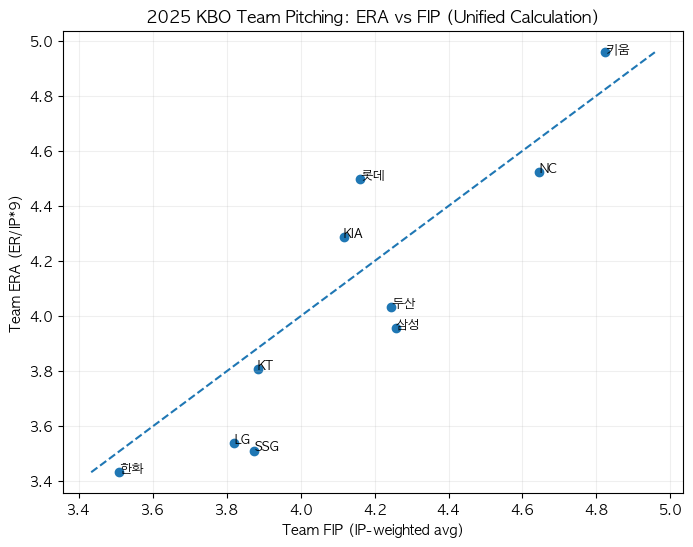


[FIP 평균 방식 차이(단순평균 - 가중평균)]
Team  FIP_player_mean  FIP_team_wavg  FIP_gap_mean_minus_wavg
  한화         3.836429       3.507041                 0.329388
 SSG         4.075714       3.873896                 0.201818
  LG         4.025714       3.818965                 0.206749
  KT         4.030000       3.883075                 0.146925
  삼성         4.268571       4.257820                 0.010751
  두산         4.308333       4.244571                 0.063763
 KIA         4.432143       4.116965                 0.315178
  롯데         4.218571       4.159850                 0.058722
  NC         4.907692       4.644770                 0.262922
  키움         4.944667       4.823150                 0.121517


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_all_2021_2025.csv"
df = pd.read_csv(PATH)

# -------------------------------------------------------
# 1) 2025 필터
# -------------------------------------------------------
df_2025 = df[df["Year"] == 2025].copy()

# 안전장치: IP/ER/FIP 결측 제거 (팀 집계에 치명적)
df_2025 = df_2025.dropna(subset=["IP", "ER", "FIP", "Team"])

# IP가 0이면 가중 평균 분모가 0이 될 수 있어 제거
df_2025 = df_2025[df_2025["IP"] > 0].copy()

# 팀 목록 확인 (정상: 10팀)
print("Teams (2025):", sorted(df_2025["Team"].unique()))
print("N teams:", df_2025["Team"].nunique())
print("Rows:", len(df_2025))

# -------------------------------------------------------
# 2) 팀 ERA / 팀 FIP 계산 (통일 규칙)
#    - 팀 ERA: (팀 ER 합 / 팀 IP 합) * 9
#    - 팀 FIP: 이닝(IP) 가중 평균 = sum(FIP*IP) / sum(IP)
# -------------------------------------------------------
team_pitch_2025 = (
    df_2025
    .assign(FIP_weighted=df_2025["FIP"] * df_2025["IP"])
    .groupby("Team", as_index=False)
    .agg(
        IP_sum=("IP", "sum"),
        ER_sum=("ER", "sum"),
        R_sum=("R", "sum"),
        FIP_w_sum=("FIP_weighted", "sum"),
        # 참고용: 선수 ERA 단순 평균(이건 "팀 ERA"랑 다름)
        ERA_player_mean=("ERA", "mean"),
        FIP_player_mean=("FIP", "mean"),
    )
)

team_pitch_2025["ERA_team_calc"] = team_pitch_2025["ER_sum"] / team_pitch_2025["IP_sum"] * 9
team_pitch_2025["FIP_team_wavg"] = team_pitch_2025["FIP_w_sum"] / team_pitch_2025["IP_sum"]

# 보기 좋게 정리
team_pitch_2025 = team_pitch_2025.sort_values("ERA_team_calc").reset_index(drop=True)

# 결과 테이블 출력 (검증용)
cols_show = [
    "Team", "IP_sum", "ER_sum",
    "ERA_team_calc", "FIP_team_wavg",
    "ERA_player_mean", "FIP_player_mean"
]
print(team_pitch_2025[cols_show].to_string(index=False))

# -------------------------------------------------------
# 3) 그래프: 2025 팀 ERA vs 팀 FIP
# -------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(team_pitch_2025["FIP_team_wavg"], team_pitch_2025["ERA_team_calc"])

for _, row in team_pitch_2025.iterrows():
    plt.text(row["FIP_team_wavg"], row["ERA_team_calc"], row["Team"], fontsize=9)

# y=x 기준선
min_v = min(team_pitch_2025["FIP_team_wavg"].min(), team_pitch_2025["ERA_team_calc"].min())
max_v = max(team_pitch_2025["FIP_team_wavg"].max(), team_pitch_2025["ERA_team_calc"].max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

plt.xlabel("Team FIP (IP-weighted avg)")
plt.ylabel("Team ERA (ER/IP*9)")
plt.title("2025 KBO Team Pitching: ERA vs FIP (Unified Calculation)")
plt.grid(alpha=0.2)
plt.show()

# -------------------------------------------------------
# 4) (선택) 팀원 수치가 왜 달랐는지 바로 보여주는 비교
#    - 단순 평균 vs 가중 평균 차이 확인
# -------------------------------------------------------
team_pitch_2025["FIP_gap_mean_minus_wavg"] = team_pitch_2025["FIP_player_mean"] - team_pitch_2025["FIP_team_wavg"]
print("\n[FIP 평균 방식 차이(단순평균 - 가중평균)]")
print(team_pitch_2025[["Team", "FIP_player_mean", "FIP_team_wavg", "FIP_gap_mean_minus_wavg"]].to_string(index=False))


Teams (2025): ['KIA', 'KT', 'LG', 'NC', 'SSG', '두산', '롯데', '삼성', '키움', '한화']
N teams: 10
Rows: 137

[팀 단순 평균 기반 결과]
Team  ERA_team_mean  FIP_team_mean  n_pitchers  IP_sum
 SSG       3.600000       4.075714          14  1176.5
  한화       3.646429       3.836429          14  1216.5
  LG       3.735714       4.025714          14  1113.8
  KT       3.808462       4.030000          13  1125.5
  삼성       4.153571       4.268571          14  1139.6
  두산       4.176667       4.308333          12  1049.3
 KIA       4.666429       4.432143          14  1092.0
  롯데       4.700714       4.218571          14  1064.5
  NC       4.728462       4.907692          13  1064.7
  키움       4.989333       4.944667          15  1067.3


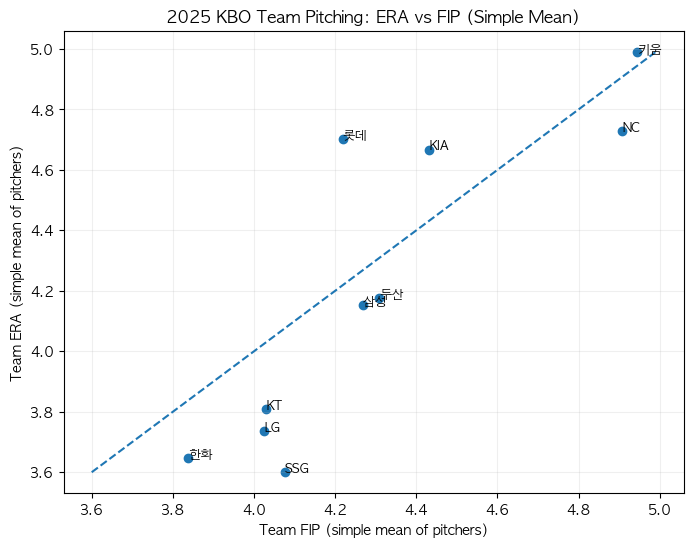


[팀별 투수 수 / 총 이닝]
Team  n_pitchers  IP_sum
  한화          14  1216.5
 SSG          14  1176.5
  삼성          14  1139.6
  KT          13  1125.5
  LG          14  1113.8
 KIA          14  1092.0
  키움          15  1067.3
  NC          13  1064.7
  롯데          14  1064.5
  두산          12  1049.3


In [ ]:
# 이거임 - 김도연
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_all_2021_2025.csv"
df = pd.read_csv(PATH)

# -------------------------------------------------------
# 1) 2025 필터
# -------------------------------------------------------
df_2025 = df[df["Year"] == 2025].copy()

# 필수 컬럼 결측 제거 (최소한만)
df_2025 = df_2025.dropna(subset=["Team", "ERA", "FIP"])

# (선택) IP가 0/결측인 투수 제거: 단순평균이긴 해도 비정상 행 제거용
df_2025 = df_2025.dropna(subset=["IP"])
df_2025 = df_2025[df_2025["IP"] > 0].copy()

print("Teams (2025):", sorted(df_2025["Team"].unique()))
print("N teams:", df_2025["Team"].nunique())
print("Rows:", len(df_2025))

# -------------------------------------------------------
# 2) 팀 ERA / 팀 FIP (단순 평균)
#    - 팀 ERA: 선수 ERA 단순 평균 (주의: 공식 팀 ERA 아님)
#    - 팀 FIP: 선수 FIP 단순 평균
# -------------------------------------------------------
team_pitch_2025_mean = (
    df_2025
    .groupby("Team", as_index=False)
    .agg(
        ERA_team_mean=("ERA", "mean"),
        FIP_team_mean=("FIP", "mean"),
        n_pitchers=("Id", "count"),
        IP_sum=("IP", "sum"),
    )
)

# 보기 좋게 정리
team_pitch_2025_mean = team_pitch_2025_mean.sort_values("ERA_team_mean").reset_index(drop=True)

print("\n[팀 단순 평균 기반 결과]")
print(team_pitch_2025_mean.to_string(index=False))

# -------------------------------------------------------
# 3) 그래프: 2025 팀 ERA vs 팀 FIP (단순 평균 버전)
# -------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(team_pitch_2025_mean["FIP_team_mean"], team_pitch_2025_mean["ERA_team_mean"])

for _, row in team_pitch_2025_mean.iterrows():
    plt.text(row["FIP_team_mean"], row["ERA_team_mean"], row["Team"], fontsize=9)

# y=x 기준선
min_v = min(team_pitch_2025_mean["FIP_team_mean"].min(), team_pitch_2025_mean["ERA_team_mean"].min())
max_v = max(team_pitch_2025_mean["FIP_team_mean"].max(), team_pitch_2025_mean["ERA_team_mean"].max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

plt.xlabel("Team FIP (simple mean of pitchers)")
plt.ylabel("Team ERA (simple mean of pitchers)")
plt.title("2025 KBO Team Pitching: ERA vs FIP (Simple Mean)")
plt.grid(alpha=0.2)
plt.show()

# -------------------------------------------------------
# 4) (선택) 팀별 투수 수/이닝 확인: 왜 결과가 달라졌는지 힌트
# -------------------------------------------------------
print("\n[팀별 투수 수 / 총 이닝]")
print(team_pitch_2025_mean[["Team", "n_pitchers", "IP_sum"]].sort_values("IP_sum", ascending=False).to_string(index=False))



---

In [7]:
STRONG_TEAMS = ["LG", "KIA", "SSG"]  # 예시
TARGET_TEAM = "한화"
YEARS = [2021, 2022, 2023, 2024, 2025]


[연도별 경기당 전체 투수 등판 수]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    8.50        8.27         8.20
2022    8.09        7.81         7.71
2023    8.59        8.38         8.31
2024    9.11        7.76         7.30
2025    9.15        7.87         7.45


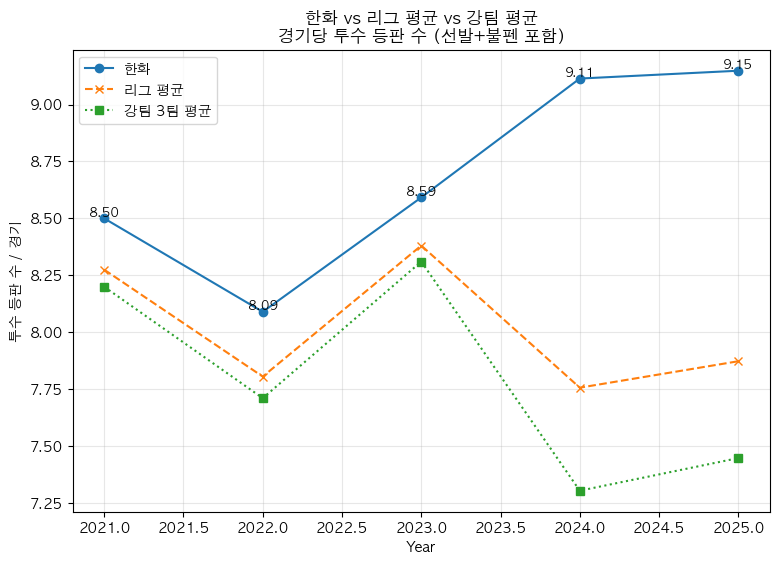

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

# -------------------------------------------------------
# 1) 기본 필터: 모든 투수 포함
# -------------------------------------------------------
df_all = df.copy()
df_all = df_all.dropna(subset=["Year", "Team", "G"])
df_all = df_all[df_all["G"] > 0]

# -------------------------------------------------------
# 2) 연도-팀별 등판 수 / 팀 경기 수
# -------------------------------------------------------
team_year_g = (
    df_all
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        total_appearances=("G", "sum"),
        team_games=("G", "max")  # 팀 경기 수 (최대값 사용)
    )
)

team_year_g["appearances_per_game"] = (
    team_year_g["total_appearances"] / team_year_g["team_games"]
)

# -------------------------------------------------------
# 3) 비교용 시계열 생성
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_g[team_year_g["Team"] == TARGET_TEAM]
    .set_index("Year")[["appearances_per_game"]]
    .rename(columns={"appearances_per_game": "Hanwha"})
)

# 리그 평균
league_avg = (
    team_year_g
    .groupby("Year")["appearances_per_game"]
    .mean()
    .to_frame("League_Avg")
)

# 강팀 3팀 평균
strong_avg = (
    team_year_g[team_year_g["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["appearances_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

# -------------------------------------------------------
# 4) 병합 테이블 (원인 점검 핵심)
# -------------------------------------------------------
compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 전체 투수 등판 수]")
print(compare_df.round(2))

# -------------------------------------------------------
# 5) 시각화 (점검용)
# -------------------------------------------------------
plt.figure(figsize=(9, 6))
plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title("한화 vs 리그 평균 vs 강팀 평균\n경기당 투수 등판 수 (선발+불펜 포함)")
plt.xlabel("Year")
plt.ylabel("투수 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


[연도별 경기당 불펜 등판 수]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    4.40        4.97         5.17
2022    5.54        5.18         5.06
2023    4.82        5.37         5.55
2024    5.29        4.57         4.33
2025    5.38        4.83         4.65


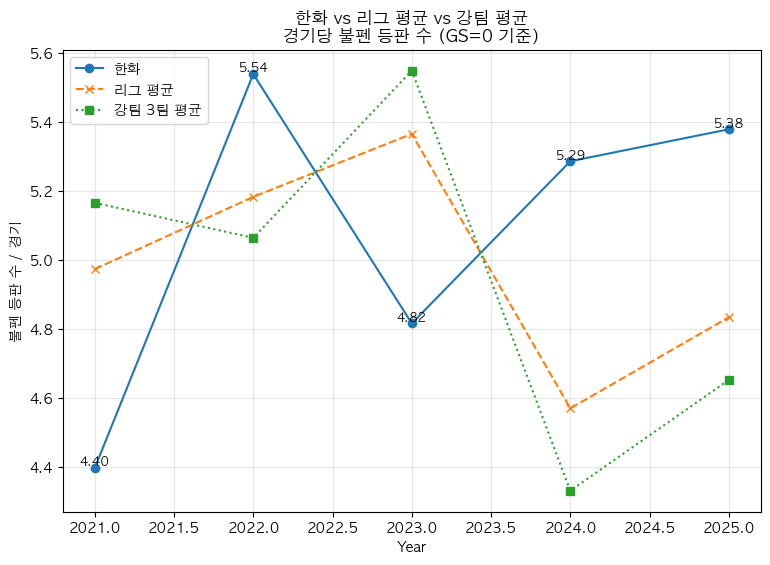

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

# -------------------------------------------------------
# 1) 불펜 투수 필터 (GS == 0)
# -------------------------------------------------------
df_bp = df[df["GS"] == 0].copy()

df_bp = df_bp.dropna(subset=["Year", "Team", "G"])
df_bp = df_bp[df_bp["G"] > 0]

# -------------------------------------------------------
# 2) 연도-팀별 불펜 등판 수 / 팀 경기 수
# -------------------------------------------------------
team_year_bp_g = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        bullpen_appearances=("G", "sum"),
        team_games=("G", "max")  # 팀 경기 수 (최대값)
    )
)

team_year_bp_g["bp_appearances_per_game"] = (
    team_year_bp_g["bullpen_appearances"] / team_year_bp_g["team_games"]
)

# -------------------------------------------------------
# 3) 비교용 시계열 생성
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_bp_g[team_year_bp_g["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_appearances_per_game"]]
    .rename(columns={"bp_appearances_per_game": "Hanwha"})
)

# 리그 평균
league_avg = (
    team_year_bp_g
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("League_Avg")
)

# 강팀 3팀 평균
strong_avg = (
    team_year_bp_g[team_year_bp_g["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

# -------------------------------------------------------
# 4) 병합 테이블 (원인 점검 핵심)
# -------------------------------------------------------
compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 불펜 등판 수]")
print(compare_df.round(2))

# -------------------------------------------------------
# 5) 시각화 (점검용)
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title("한화 vs 리그 평균 vs 강팀 평균\n경기당 불펜 등판 수 (GS=0 기준)")
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


불펜 투수 수(연도별):
Year
2021    38
2022    32
2023    40
2024    35
2025    34
Name: Id, dtype: int64

[연도별 경기당 불펜 등판 수 (새 기준)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    6.19        6.20         6.21
2022    6.17        5.69         5.53
2023    6.57        6.37         6.30
2024    7.13        5.83         5.40
2025    6.93        5.95         5.63


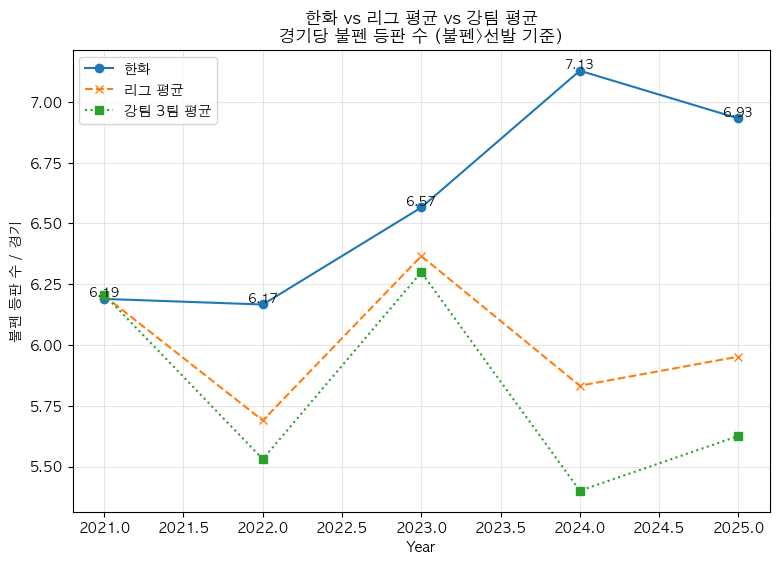

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

# -------------------------------------------------------
# 1) 새 불펜 정의
#    - 불펜 등판 수 = G - GS
#    - (G - GS) > GS 인 투수만 불펜으로 간주
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["G"] > 0].copy()

df["BP_G"] = df["G"] - df["GS"]

df_bp = df[df["BP_G"] > df["GS"]].copy()

print("불펜 투수 수(연도별):")
print(df_bp.groupby("Year")["Id"].count())

# -------------------------------------------------------
# 2) 연도-팀별 불펜 등판 수 / 팀 경기 수
# -------------------------------------------------------
team_year_bp = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        bullpen_appearances=("BP_G", "sum"),
        team_games=("G", "max")
    )
)

team_year_bp["bp_appearances_per_game"] = (
    team_year_bp["bullpen_appearances"] / team_year_bp["team_games"]
)

# -------------------------------------------------------
# 3) 비교용 시계열 생성
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_bp[team_year_bp["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_appearances_per_game"]]
    .rename(columns={"bp_appearances_per_game": "Hanwha"})
)

# 리그 평균
league_avg = (
    team_year_bp
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("League_Avg")
)

# 강팀 3팀 평균
strong_avg = (
    team_year_bp[team_year_bp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

# -------------------------------------------------------
# 4) 병합 테이블 (원인 점검 핵심)
# -------------------------------------------------------
compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 불펜 등판 수 (새 기준)]")
print(compare_df.round(2))

# -------------------------------------------------------
# 5) 시각화 (점검용)
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 불펜 등판 수 (불펜>선발 기준)"
)
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[연도별 경기당 불펜 등판 수 (게임 수=144 고정)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    2.49        2.82         2.93
2022    3.34        2.83         2.66
2023    3.47        3.27         3.20
2024    3.47        2.97         2.80
2025    3.56        3.13         2.98


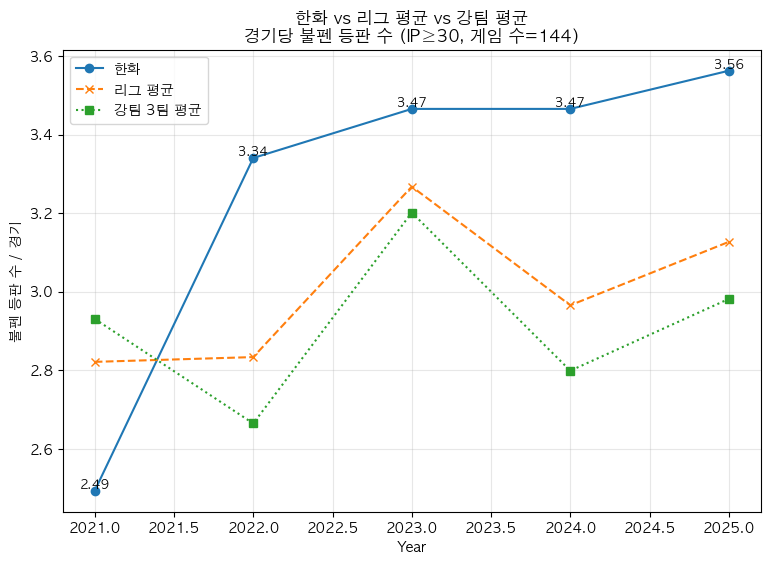

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

TEAM_GAMES = {
    2021: 144,
    2022: 144,
    2023: 144,
    2024: 144,
    2025: 144
}

# -------------------------------------------------------
# 1) 새 불펜 정의 유지
#    - 불펜 등판 수 = G - GS
#    - (G - GS) > GS
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["G"] > 0].copy()

df["BP_G"] = df["G"] - df["GS"]
df_bp = df[df["BP_G"] > df["GS"]].copy()

# -------------------------------------------------------
# 2) 연도-팀별 불펜 등판 수 합
# -------------------------------------------------------
team_year_bp = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        bullpen_appearances=("BP_G", "sum")
    )
)

# -------------------------------------------------------
# 3) 경기당 불펜 등판 수 (분모 = 144 고정)
# -------------------------------------------------------
team_year_bp["games"] = team_year_bp["Year"].map(TEAM_GAMES)
team_year_bp["bp_appearances_per_game"] = (
    team_year_bp["bullpen_appearances"] / team_year_bp["games"]
)

# -------------------------------------------------------
# 4) 비교용 시계열
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_bp[team_year_bp["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_appearances_per_game"]]
    .rename(columns={"bp_appearances_per_game": "Hanwha"})
)

# 리그 평균
league_avg = (
    team_year_bp
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("League_Avg")
)

# 강팀 3팀 평균
strong_avg = (
    team_year_bp[team_year_bp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_appearances_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 불펜 등판 수 (게임 수=144 고정)]")
print(compare_df.round(2))

# -------------------------------------------------------
# 5) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 불펜 등판 수 (IP≥30, 게임 수=144)"
)
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[연도별 경기당 선발 등판 수 (불펜 제외 / 게임 수=144 고정)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   0.771       0.714        0.656
2022   0.840       0.913        0.917
2023   0.722       0.830        0.837
2024   0.722       0.839        0.906
2025   0.944       0.872        0.819


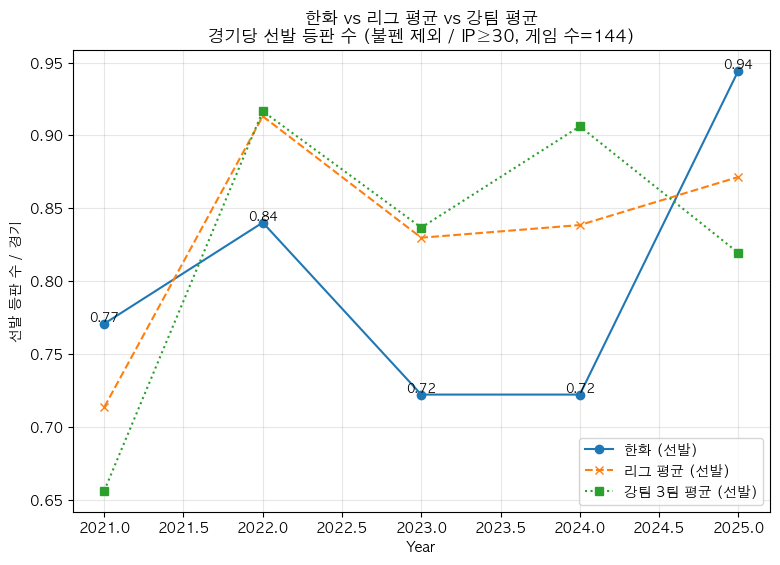

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KT", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}

# -------------------------------------------------------
# 1) 선발 정의 (불펜 제외)
#    - BP_G = G - GS
#    - 선발투수: GS >= BP_G  (즉, 2*GS >= G)
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["G"] > 0].copy()

df["BP_G"] = df["G"] - df["GS"]

df_sp = df[df["GS"] >= df["BP_G"]].copy()   # ✅ 선발 위주 투수만

# -------------------------------------------------------
# 2) 연도-팀별 선발 등판 수 합 (여기서는 'GS' 합이 선발 등판 수)
# -------------------------------------------------------
team_year_sp = (
    df_sp
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        starter_starts=("GS", "sum")
    )
)

# -------------------------------------------------------
# 3) 경기당 선발 등판 수 (분모 = 144 고정)
# -------------------------------------------------------
team_year_sp["games"] = team_year_sp["Year"].map(TEAM_GAMES)
team_year_sp["sp_starts_per_game"] = team_year_sp["starter_starts"] / team_year_sp["games"]

# -------------------------------------------------------
# 4) 비교용 시계열
# -------------------------------------------------------
hanwha = (
    team_year_sp[team_year_sp["Team"] == TARGET_TEAM]
    .set_index("Year")[["sp_starts_per_game"]]
    .rename(columns={"sp_starts_per_game": "Hanwha"})
)

league_avg = (
    team_year_sp
    .groupby("Year")["sp_starts_per_game"]
    .mean()
    .to_frame("League_Avg")
)

strong_avg = (
    team_year_sp[team_year_sp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["sp_starts_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 선발 등판 수 (불펜 제외 / 게임 수=144 고정)]")
print(compare_df.round(3))

# -------------------------------------------------------
# 5) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화 (선발)")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균 (선발)")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균 (선발)")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 선발 등판 수 (불펜 제외 / IP≥30, 게임 수=144)"
)
plt.xlabel("Year")
plt.ylabel("선발 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[연도별 경기당 총 투수 등판 수 (모든 투수 포함 / 게임 수=144)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    3.42        3.76         3.94
2022    4.38        3.89         3.91
2023    4.53        4.30         4.37
2024    4.43        3.94         3.54
2025    4.70        4.14         4.02


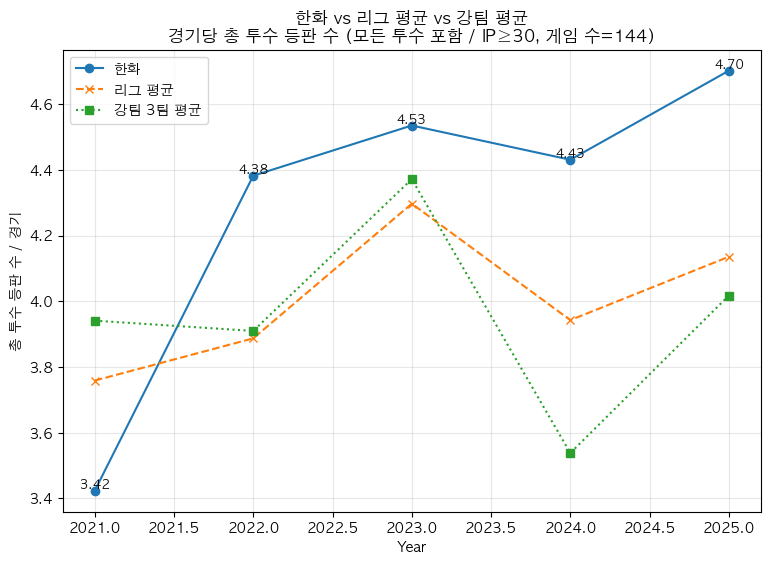

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KT", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}

# -------------------------------------------------------
# 1) 모든 투수 포함 (등판 수 = G)
# -------------------------------------------------------
df_all = df.dropna(subset=["Year", "Team", "G"]).copy()
df_all = df_all[df_all["Year"].isin(YEARS)]
df_all = df_all[df_all["G"] > 0]

# -------------------------------------------------------
# 2) 연도-팀별 총 등판 수 합
# -------------------------------------------------------
team_year_all = (
    df_all
    .groupby(["Year", "Team"], as_index=False)
    .agg(
        total_appearances=("G", "sum")
    )
)

# -------------------------------------------------------
# 3) 경기당 총 등판 수 (분모 = 144 고정)
# -------------------------------------------------------
team_year_all["games"] = team_year_all["Year"].map(TEAM_GAMES)
team_year_all["appearances_per_game"] = team_year_all["total_appearances"] / team_year_all["games"]

# -------------------------------------------------------
# 4) 비교용 시계열 (한화 / 리그 평균 / 강팀 3팀 평균)
# -------------------------------------------------------
hanwha = (
    team_year_all[team_year_all["Team"] == TARGET_TEAM]
    .set_index("Year")[["appearances_per_game"]]
    .rename(columns={"appearances_per_game": "Hanwha"})
)

league_avg = (
    team_year_all
    .groupby("Year")["appearances_per_game"]
    .mean()
    .to_frame("League_Avg")
)

strong_avg = (
    team_year_all[team_year_all["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["appearances_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[연도별 경기당 총 투수 등판 수 (모든 투수 포함 / 게임 수=144)]")
print(compare_df.round(2))

# -------------------------------------------------------
# 5) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 총 투수 등판 수 (모든 투수 포함 / IP≥30, 게임 수=144)"
)
plt.xlabel("Year")
plt.ylabel("총 투수 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[연도별 경기당 불펜 등판 수]
 - Hanwha: 팀 값(144로 나눔)
 - League_Avg_B: 리그 전체 합 / (10팀*144)
 - Strong3_Avg: 3팀 팀별 값 평균
      Hanwha  League_Avg_B  Strong3_Avg
Year                                   
2021    2.49          1.13         3.02
2022    3.34          1.13         2.86
2023    3.47          1.31         3.34
2024    3.47          1.19         2.55
2025    3.56          1.25         3.05


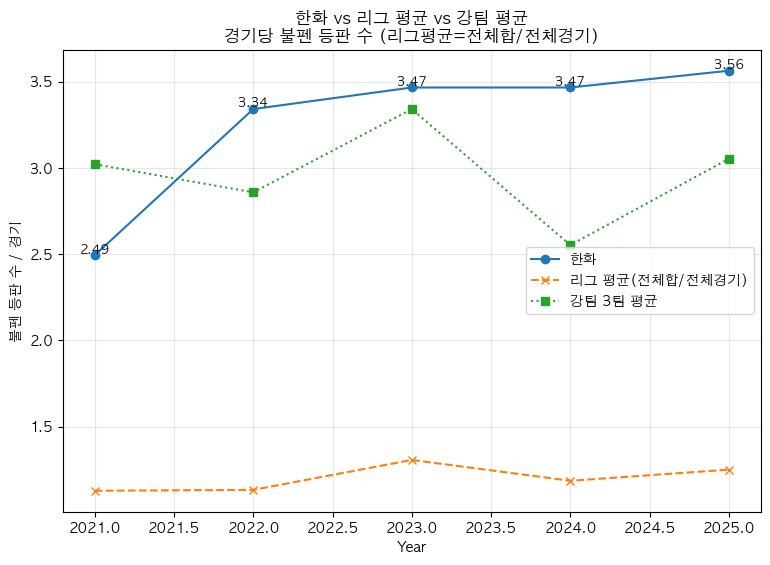

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KT", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}
N_TEAMS = 10  # 리그 팀 수(2021~2025는 10팀 기준)

# -------------------------------------------------------
# 1) 불펜 정의: 불펜 등판(BP_G) > 선발 등판(GS)
#    - BP_G = G - GS
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["Year"].isin(YEARS) & (df["G"] > 0)].copy()

df["BP_G"] = df["G"] - df["GS"]
df_bp = df[df["BP_G"] > df["GS"]].copy()

# -------------------------------------------------------
# 2) 팀-연도별 불펜 등판 수 합
# -------------------------------------------------------
team_year_bp = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(bullpen_appearances=("BP_G", "sum"))
)

# -------------------------------------------------------
# 3) 경기당 불펜 등판 수 (한화 / 강팀 3팀 평균)
#    - 한화/강팀은 "팀별 값 -> 평균" 방식(A) 그대로 유지해도 되고,
#      원인 비교를 위해 리그 평균만 (B) 방식으로 계산하는 게 목적임.
# -------------------------------------------------------
team_year_bp["games"] = team_year_bp["Year"].map(TEAM_GAMES)
team_year_bp["bp_per_game_team"] = team_year_bp["bullpen_appearances"] / team_year_bp["games"]

hanwha = (
    team_year_bp[team_year_bp["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_per_game_team"]]
    .rename(columns={"bp_per_game_team": "Hanwha"})
)

strong_avg = (
    team_year_bp[team_year_bp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_per_game_team"]
    .mean()
    .to_frame("Strong3_Avg")
)

# -------------------------------------------------------
# 4) ✅ 리그 평균: 경우 B (리그 전체 합 / 리그 전체 경기 수)
#    - 리그 전체 불펜 등판 합 ÷ (10팀 * 144경기)
# -------------------------------------------------------
league_total_avg_B = (
    team_year_bp
    .groupby("Year")["bullpen_appearances"].sum()
    / (N_TEAMS * pd.Series(TEAM_GAMES))
).to_frame("League_Avg_B")

# 위에서 TEAM_GAMES를 Series로 나눌 때 Year index가 맞도록 정렬
league_total_avg_B.index = league_total_avg_B.index.astype(int)

# -------------------------------------------------------
# 5) 병합 & 출력
# -------------------------------------------------------
compare_df = hanwha.join(league_total_avg_B).join(strong_avg)

print("\n[연도별 경기당 불펜 등판 수]")
print(" - Hanwha: 팀 값(144로 나눔)")
print(" - League_Avg_B: 리그 전체 합 / (10팀*144)")
print(" - Strong3_Avg: 3팀 팀별 값 평균")
print(compare_df.round(2))

# -------------------------------------------------------
# 6) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))
plt.plot(compare_df.index, compare_df["Hanwha"], marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg_B"], marker="x", linestyle="--", label="리그 평균(전체합/전체경기)")
plt.plot(compare_df.index, compare_df["Strong3_Avg"], marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"], f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title("한화 vs 리그 평균 vs 강팀 평균\n경기당 불펜 등판 수 (리그평균=전체합/전체경기)")
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[GR 기준: 연도별 경기당 불펜 등판 수]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    2.55        2.88         2.99
2022    3.51        2.94         2.75
2023    3.55        3.34         3.27
2024    3.47        3.01         2.85
2025    3.73        3.18         3.00


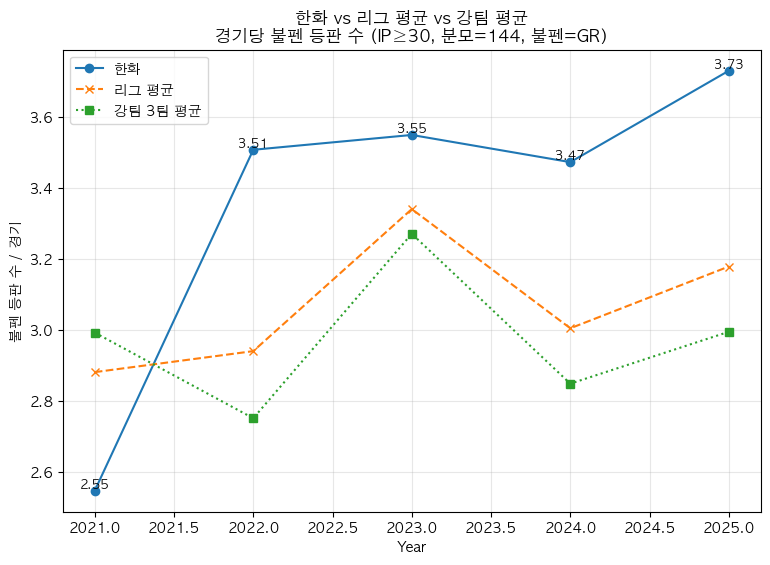

In [ ]:
# 이거임 - 장재영님
import pandas as pd
import matplotlib.pyplot as plt

PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}

# 1) 기본 필터 (IP>=30 파일을 그대로 쓰는 전제)
df = df[df["Year"].isin(YEARS)].copy()
df = df.dropna(subset=["Year", "Team", "GR"])
df = df[df["GR"] >= 0]  # GR은 0도 가능

# 2) 팀-연도별 불펜 등판(=GR 합)
team_year = (
    df.groupby(["Year", "Team"], as_index=False)
      .agg(bullpen_appearances=("GR", "sum"))
)

# 3) 경기당(144)으로 나누기
team_year["games"] = team_year["Year"].map(TEAM_GAMES)
team_year["bp_per_game"] = team_year["bullpen_appearances"] / team_year["games"]
# 4) 비교선 만들기
hanwha = (
    team_year[team_year["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_per_game"]]
    .rename(columns={"bp_per_game":"Hanwha"})
)

league_avg = (
    team_year.groupby("Year")["bp_per_game"].mean()
    .to_frame("League_Avg")
)

strong_avg = (
    team_year[team_year["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_per_game"].mean()
    .to_frame("Strong3_Avg")
)

compare_df = hanwha.join(league_avg).join(strong_avg)
print("\n[GR 기준: 연도별 경기당 불펜 등판 수]")
print(compare_df.round(2))

# 5) 그래프
plt.figure(figsize=(9, 6))
plt.plot(compare_df.index, compare_df["Hanwha"], marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"], marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"], marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"], f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title("한화 vs 리그 평균 vs 강팀 평균\n경기당 불펜 등판 수 (IP≥30, 분모=144, 불펜=GR)")
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


   Year  bp_per_game
0  2021         2.55
1  2022         3.51
2  2023         3.55
3  2024         3.47
4  2025         3.73


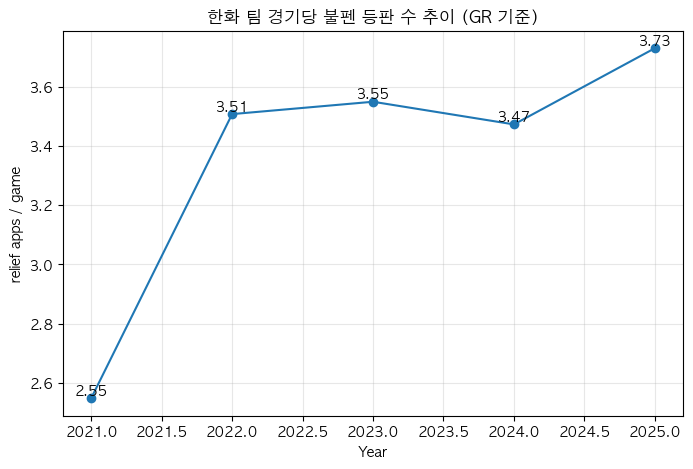

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}

# 1) 필터
df = df[df["Year"].isin(YEARS)].copy()
df = df.dropna(subset=["Team", "GR"])
df = df[df["GR"] >= 0]

# 2) 팀-연도별 불펜 등판 수 합 (GR)
team_year = (
    df[df["Team"] == TARGET_TEAM]
    .groupby("Year", as_index=False)
    .agg(bullpen_appearances=("GR", "sum"))
)

# 3) 경기당 계산
team_year["games"] = team_year["Year"].map(TEAM_GAMES)
team_year["bp_per_game"] = team_year["bullpen_appearances"] / team_year["games"]

print(team_year[["Year", "bp_per_game"]].round(2))

# 4) 그래프
plt.figure(figsize=(8, 5))
plt.plot(team_year["Year"], team_year["bp_per_game"], marker="o")

for _, row in team_year.iterrows():
    plt.text(row["Year"], row["bp_per_game"],
             f"{row['bp_per_game']:.2f}",
             ha="center", va="bottom")

plt.title("한화 팀 경기당 불펜 등판 수 추이 (GR 기준)")
plt.xlabel("Year")
plt.ylabel("relief apps / game")
plt.grid(alpha=0.3)
plt.show()



[팀 총 투수 이닝 / 경기 (Total IP per Game)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   7.142       7.516        7.641
2022   7.581       7.840        7.927
2023   8.252       8.234        8.228
2024   8.094       7.662        7.518
2025   8.448       7.984        7.829

[불펜 소화 이닝 / 경기 (v1: GR>0 투수)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   6.142       5.292        5.008
2022   5.530       4.569        4.248
2023   4.971       5.534        5.722
2024   4.965       5.210        5.292
2025   4.993       4.383        4.179

[불펜 소화 이닝 / 경기 (v2: GR>GS 투수)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   3.036       3.680        3.894
2022   3.284       2.804        2.644
2023   4.492       3.754        3.508
2024   4.324       3.231        2.866
2025   3.207       3.238        3.248

[불펜 이닝 비중 (v1)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   0

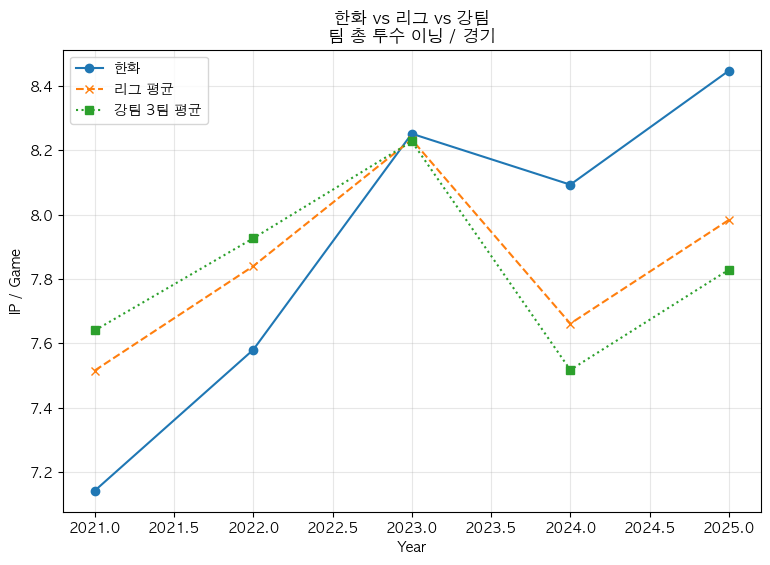

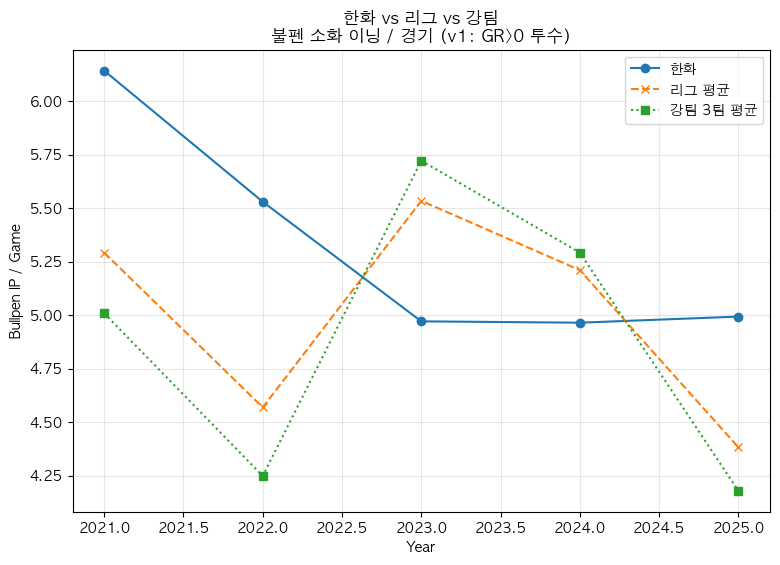

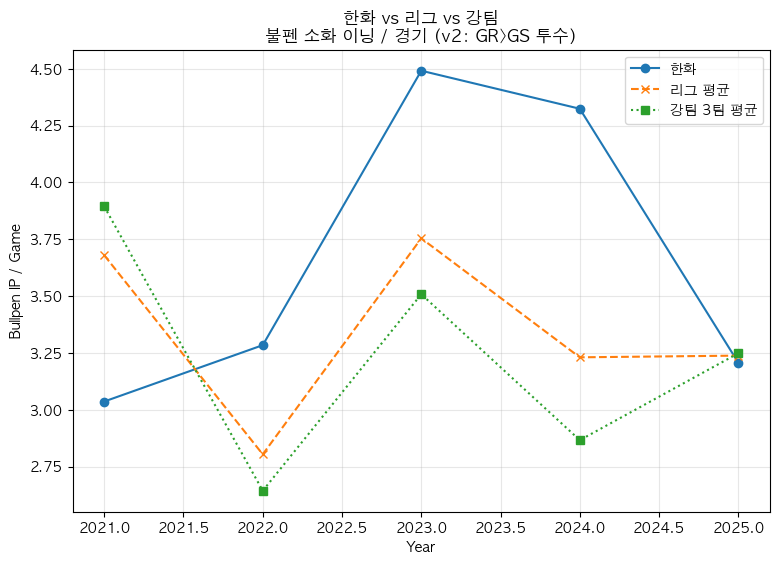

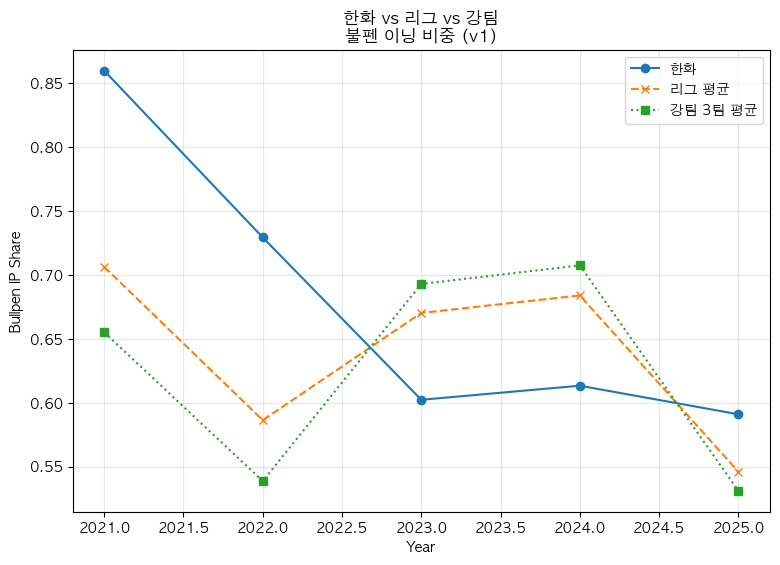

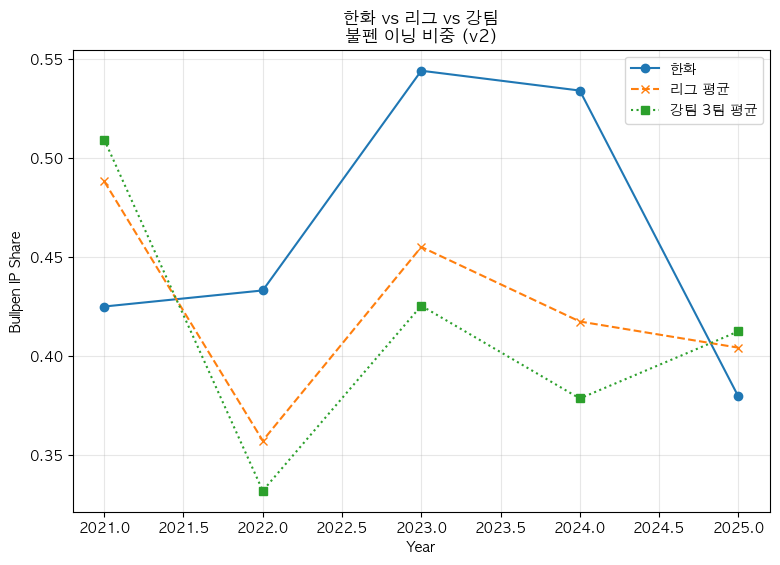

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {2021:144, 2022:144, 2023:144, 2024:144, 2025:144}

# -------------------------------------------------------
# 1) 기본 필터
# -------------------------------------------------------
df = df[df["Year"].isin(YEARS)].copy()
df = df.dropna(subset=["Year", "Team", "IP", "G", "GS"])
df = df[df["IP"] > 0].copy()

# -------------------------------------------------------
# 2) 팀-연도별 총 투수 이닝 (Total IP)
# -------------------------------------------------------
team_year_ip = (
    df.groupby(["Year", "Team"], as_index=False)
      .agg(total_ip=("IP", "sum"))
)

team_year_ip["games"] = team_year_ip["Year"].map(TEAM_GAMES)
team_year_ip["total_ip_per_game"] = team_year_ip["total_ip"] / team_year_ip["games"]

# -------------------------------------------------------
# 3) (옵션) 불펜 이닝 추정 1: "불펜투수"를 정의해서 그 투수들의 IP 합
#    - 가장 단순/재현 쉬움: "구원 등판이 있는 투수"를 불펜 후보로 보고 IP 합
#    - 단점: 스윙맨(선발+불펜) 포함 가능
# -------------------------------------------------------
df_bp_candidate = df[df["GR"] > 0].copy() if "GR" in df.columns else df.copy()

team_year_bp_ip_1 = (
    df_bp_candidate.groupby(["Year", "Team"], as_index=False)
      .agg(bullpen_ip_v1=("IP", "sum"))
)

# -------------------------------------------------------
# 4) (옵션) 불펜 이닝 추정 2: "불펜 위주 투수"만 잡아서 IP 합
#    - 기준: GR > GS  (구원이 선발보다 많은 투수)
#    - 장점: 스윙맨 일부 제거
# -------------------------------------------------------
df["is_bp_major"] = df["GR"] > df["GS"] if "GR" in df.columns else False
df_bp_major = df[df["is_bp_major"]].copy()

team_year_bp_ip_2 = (
    df_bp_major.groupby(["Year", "Team"], as_index=False)
      .agg(bullpen_ip_v2=("IP", "sum"))
)

# -------------------------------------------------------
# 5) 병합 + 경기당/비중 계산
# -------------------------------------------------------
team_year = team_year_ip.merge(team_year_bp_ip_1, on=["Year", "Team"], how="left")
team_year = team_year.merge(team_year_bp_ip_2, on=["Year", "Team"], how="left")

team_year["bullpen_ip_v1"] = team_year["bullpen_ip_v1"].fillna(0)
team_year["bullpen_ip_v2"] = team_year["bullpen_ip_v2"].fillna(0)

team_year["bullpen_ip_v1_per_game"] = team_year["bullpen_ip_v1"] / team_year["games"]
team_year["bullpen_ip_v2_per_game"] = team_year["bullpen_ip_v2"] / team_year["games"]

team_year["bullpen_ip_share_v1"] = team_year["bullpen_ip_v1"] / team_year["total_ip"]
team_year["bullpen_ip_share_v2"] = team_year["bullpen_ip_v2"] / team_year["total_ip"]

# -------------------------------------------------------
# 6) 비교선 만들기 (한화 / 리그평균 / 강팀평균)
#    - 원하는 지표를 골라서 그리면 됨
# -------------------------------------------------------
def make_compare(metric_col, metric_name):
    hanwha = (
        team_year[team_year["Team"] == TARGET_TEAM]
        .set_index("Year")[[metric_col]]
        .rename(columns={metric_col: "Hanwha"})
    )
    league_avg = (
        team_year.groupby("Year")[metric_col]
        .mean()
        .to_frame("League_Avg")
    )
    strong_avg = (
        team_year[team_year["Team"].isin(STRONG_TEAMS)]
        .groupby("Year")[metric_col]
        .mean()
        .to_frame("Strong3_Avg")
    )
    compare_df = hanwha.join(league_avg).join(strong_avg)
    print(f"\n[{metric_name}]")
    print(compare_df.round(3))
    return compare_df

# A) 팀 총 투수 이닝 / 경기 (거의 9 근처가 정상)
compare_total_ip = make_compare("total_ip_per_game", "팀 총 투수 이닝 / 경기 (Total IP per Game)")

# B-1) 불펜 소화 이닝 / 경기 (v1: GR>0 투수 IP 합)
compare_bp_ip_v1 = make_compare("bullpen_ip_v1_per_game", "불펜 소화 이닝 / 경기 (v1: GR>0 투수)")

# B-2) 불펜 소화 이닝 / 경기 (v2: GR>GS 투수 IP 합)
compare_bp_ip_v2 = make_compare("bullpen_ip_v2_per_game", "불펜 소화 이닝 / 경기 (v2: GR>GS 투수)")

# (선택) 불펜 이닝 비중
compare_bp_share_v1 = make_compare("bullpen_ip_share_v1", "불펜 이닝 비중 (v1)")
compare_bp_share_v2 = make_compare("bullpen_ip_share_v2", "불펜 이닝 비중 (v2)")

# -------------------------------------------------------
# 7) 시각화 함수
# -------------------------------------------------------
def plot_compare(compare_df, title, ylabel):
    plt.figure(figsize=(9, 6))
    plt.plot(compare_df.index, compare_df["Hanwha"], marker="o", label="한화")
    plt.plot(compare_df.index, compare_df["League_Avg"], marker="x", linestyle="--", label="리그 평균")
    plt.plot(compare_df.index, compare_df["Strong3_Avg"], marker="s", linestyle=":", label="강팀 3팀 평균")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# 원하는 것만 골라서 그리기
# 1번이 재영님꺼
plot_compare(compare_total_ip, "한화 vs 리그 vs 강팀\n팀 총 투수 이닝 / 경기", "IP / Game")
plot_compare(compare_bp_ip_v1, "한화 vs 리그 vs 강팀\n불펜 소화 이닝 / 경기 (v1: GR>0 투수)", "Bullpen IP / Game")
plot_compare(compare_bp_ip_v2, "한화 vs 리그 vs 강팀\n불펜 소화 이닝 / 경기 (v2: GR>GS 투수)", "Bullpen IP / Game")
plot_compare(compare_bp_share_v1, "한화 vs 리그 vs 강팀\n불펜 이닝 비중 (v1)", "Bullpen IP Share")
plot_compare(compare_bp_share_v2, "한화 vs 리그 vs 강팀\n불펜 이닝 비중 (v2)", "Bullpen IP Share")



[재영님 방식: 경기당 불펜 등판 수 (GR / 144)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   2.549       2.882        3.087
2022   3.507       2.941        2.944
2023   3.549       3.340        3.434
2024   3.472       3.005        2.615
2025   3.729       3.179        3.073

[혜민님 방식: 투수 등판 대비 불펜 비중 (GR / ∑G)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021   0.744       0.766        0.783
2022   0.800       0.749        0.744
2023   0.783       0.776        0.785
2024   0.784       0.758        0.734
2025   0.793       0.767        0.764


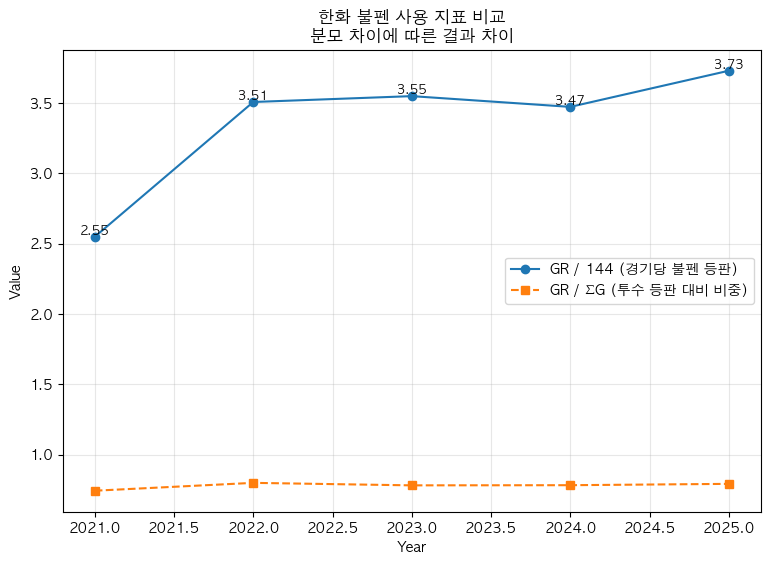

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KT", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {y:144 for y in YEARS}

# -------------------------------------------------------
# 1) 기본 필터
# -------------------------------------------------------
df = df[df["Year"].isin(YEARS)].copy()
df = df.dropna(subset=["Year", "Team", "GR", "G"])
df = df[df["GR"] >= 0]

# -------------------------------------------------------
# 2) 팀-연도별 집계
# -------------------------------------------------------
team_year = (
    df.groupby(["Year", "Team"], as_index=False)
      .agg(
          GR_sum=("GR", "sum"),   # 불펜 등판 수
          G_sum=("G", "sum")      # 투수 G 합 (혜민님 분모)
      )
)

# -------------------------------------------------------
# 3) 두 가지 방식 계산
# -------------------------------------------------------
# 재영님 방식: 경기당 불펜 등판 수
team_year["bp_per_game_144"] = (
    team_year["GR_sum"] / team_year["Year"].map(TEAM_GAMES)
)

# 혜민님 방식: 투수 등판 대비 불펜 비중
team_year["bp_per_pitching_G"] = (
    team_year["GR_sum"] / team_year["G_sum"]
)

# -------------------------------------------------------
# 4) 비교 테이블 (한화 / 리그 평균 / 강팀 평균)
# -------------------------------------------------------
def make_compare(metric_col):
    hanwha = (
        team_year[team_year["Team"] == TARGET_TEAM]
        .set_index("Year")[[metric_col]]
        .rename(columns={metric_col: "Hanwha"})
    )
    league_avg = (
        team_year.groupby("Year")[metric_col]
        .mean()
        .to_frame("League_Avg")
    )
    strong_avg = (
        team_year[team_year["Team"].isin(STRONG_TEAMS)]
        .groupby("Year")[metric_col]
        .mean()
        .to_frame("Strong3_Avg")
    )
    return hanwha.join(league_avg).join(strong_avg)

compare_144 = make_compare("bp_per_game_144")
compare_G   = make_compare("bp_per_pitching_G")

print("\n[재영님 방식: 경기당 불펜 등판 수 (GR / 144)]")
print(compare_144.round(3))

print("\n[혜민님 방식: 투수 등판 대비 불펜 비중 (GR / ∑G)]")
print(compare_G.round(3))

# -------------------------------------------------------
# 5) 시각화 (한화 기준 비교)
# -------------------------------------------------------
plt.figure(figsize=(9,6))
plt.plot(compare_144.index, compare_144["Hanwha"],
         marker="o", label="GR / 144 (경기당 불펜 등판)")
plt.plot(compare_G.index, compare_G["Hanwha"],
         marker="s", linestyle="--", label="GR / ∑G (투수 등판 대비 비중)")

for y in compare_144.index:
    plt.text(y, compare_144.loc[y, "Hanwha"],
             f"{compare_144.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title("한화 불펜 사용 지표 비교\n분모 차이에 따른 결과 차이")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[불펜 비중 50% 기준: 경기당 불펜 등판 수]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    2.49        1.13         2.93
2022    3.34        1.13         2.66
2023    3.47        1.31         3.20
2024    3.47        1.19         2.80
2025    3.56        1.25         2.98


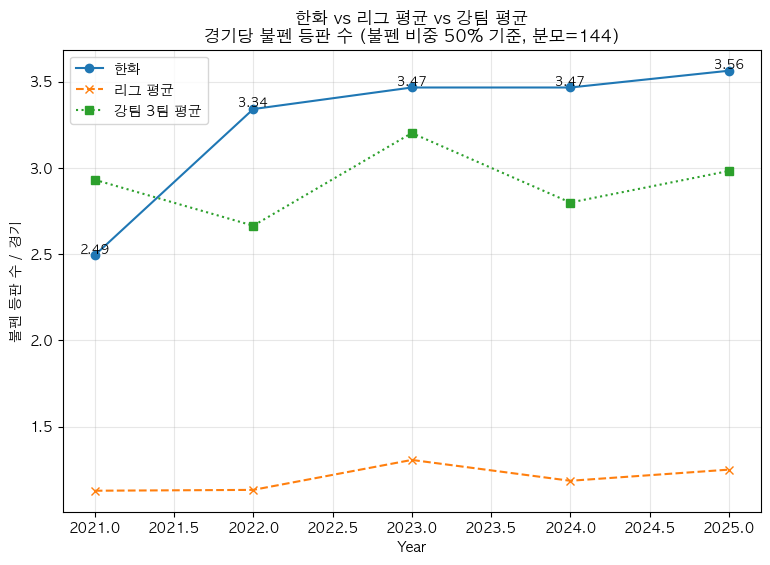

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]

TEAM_GAMES = {y:144 for y in YEARS}
N_TEAMS = 10  # KBO 팀 수

# -------------------------------------------------------
# 1) 기본 필터
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["Year"].isin(YEARS) & (df["G"] > 0)].copy()

# -------------------------------------------------------
# 2) 불펜 정의 (50% 기준)
#    - BP_G = G - GS
#    - BP_G > GS  → 불펜 위주 투수
# -------------------------------------------------------
df["BP_G"] = df["G"] - df["GS"]
df_bp = df[df["BP_G"] > df["GS"]].copy()

# -------------------------------------------------------
# 3) 팀-연도별 불펜 등판 수 합
# -------------------------------------------------------
team_year_bp = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(bullpen_appearances=("BP_G", "sum"))
)

# -------------------------------------------------------
# 4) 경기당 불펜 등판 수 (분모=144 고정)
# -------------------------------------------------------
team_year_bp["games"] = team_year_bp["Year"].map(TEAM_GAMES)
team_year_bp["bp_per_game"] = team_year_bp["bullpen_appearances"] / team_year_bp["games"]

# -------------------------------------------------------
# 5) 비교선 생성
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_bp[team_year_bp["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_per_game"]]
    .rename(columns={"bp_per_game": "Hanwha"})
)

# 강팀 3팀 평균 (팀별 값 평균)
strong_avg = (
    team_year_bp[team_year_bp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

# 리그 평균 (전체 합 / 전체 경기 수)
league_avg = (
    team_year_bp
    .groupby("Year")["bullpen_appearances"]
    .sum()
    / (N_TEAMS * pd.Series(TEAM_GAMES))
).to_frame("League_Avg")

league_avg.index = league_avg.index.astype(int)

# -------------------------------------------------------
# 6) 병합 테이블
# -------------------------------------------------------
compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[불펜 비중 50% 기준: 경기당 불펜 등판 수]")
print(compare_df.round(2))

# -------------------------------------------------------
# 7) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"],
         marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"],
         marker="x", linestyle="--", label="리그 평균")
plt.plot(compare_df.index, compare_df["Strong3_Avg"],
         marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 불펜 등판 수 (불펜 비중 50% 기준, 분모=144)"
)
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[불펜 비중 50% 기준: 경기당 불펜 등판 수 (리그평균=팀평균)]
      Hanwha  League_Avg  Strong3_Avg
Year                                 
2021    2.49        2.82         2.93
2022    3.34        2.83         2.66
2023    3.47        3.27         3.20
2024    3.47        2.97         2.80
2025    3.56        3.13         2.98


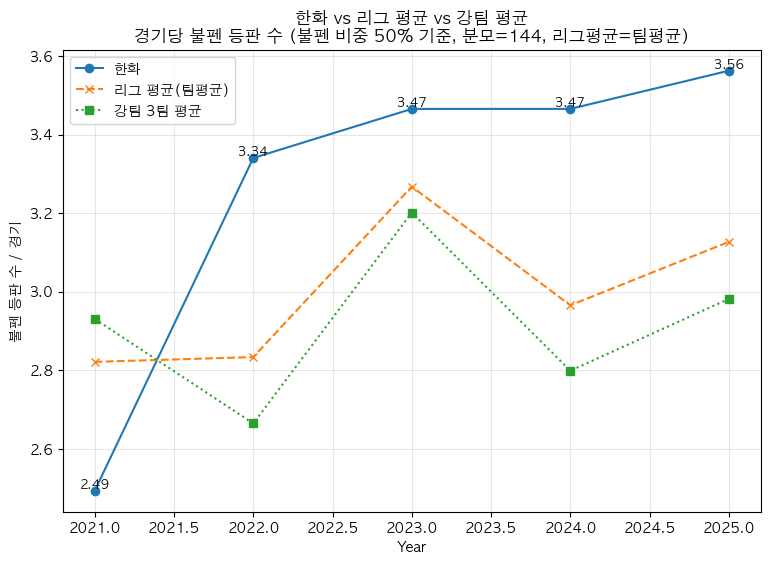

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_2021_2025.csv"
df = pd.read_csv(PATH)

TARGET_TEAM = "한화"
STRONG_TEAMS = ["LG", "KIA", "SSG"]
YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {y: 144 for y in YEARS}

# -------------------------------------------------------
# 1) 기본 필터
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["Year"].isin(YEARS) & (df["G"] > 0)].copy()

# -------------------------------------------------------
# 2) 불펜 정의 (50% 기준)
#    - BP_G = G - GS
#    - BP_G > GS  → 불펜 위주 투수
# -------------------------------------------------------
df["BP_G"] = df["G"] - df["GS"]
df_bp = df[df["BP_G"] > df["GS"]].copy()

# -------------------------------------------------------
# 3) 팀-연도별 불펜 등판 수 합
# -------------------------------------------------------
team_year_bp = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(bullpen_appearances=("BP_G", "sum"))
)

# -------------------------------------------------------
# 4) 경기당 불펜 등판 수 (분모=144 고정)
# -------------------------------------------------------
team_year_bp["games"] = team_year_bp["Year"].map(TEAM_GAMES)
team_year_bp["bp_per_game"] = team_year_bp["bullpen_appearances"] / team_year_bp["games"]

# -------------------------------------------------------
# 5) 비교선 생성 (여기서 리그 평균을 "팀 평균"으로 통일)
# -------------------------------------------------------
# 한화
hanwha = (
    team_year_bp[team_year_bp["Team"] == TARGET_TEAM]
    .set_index("Year")[["bp_per_game"]]
    .rename(columns={"bp_per_game": "Hanwha"})
)

# 리그 평균: (10팀의 bp_per_game) 평균  ✅ 통일된 방식
league_avg = (
    team_year_bp
    .groupby("Year")["bp_per_game"]
    .mean()
    .to_frame("League_Avg")
)

# 강팀 3팀 평균
strong_avg = (
    team_year_bp[team_year_bp["Team"].isin(STRONG_TEAMS)]
    .groupby("Year")["bp_per_game"]
    .mean()
    .to_frame("Strong3_Avg")
)

compare_df = hanwha.join(league_avg).join(strong_avg)

print("\n[불펜 비중 50% 기준: 경기당 불펜 등판 수 (리그평균=팀평균)]")
print(compare_df.round(2))

# -------------------------------------------------------
# 6) 시각화
# -------------------------------------------------------
plt.figure(figsize=(9, 6))

plt.plot(compare_df.index, compare_df["Hanwha"], marker="o", label="한화")
plt.plot(compare_df.index, compare_df["League_Avg"], marker="x", linestyle="--", label="리그 평균(팀평균)")
plt.plot(compare_df.index, compare_df["Strong3_Avg"], marker="s", linestyle=":", label="강팀 3팀 평균")

for y in compare_df.index:
    plt.text(y, compare_df.loc[y, "Hanwha"],
             f"{compare_df.loc[y, 'Hanwha']:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.title(
    "한화 vs 리그 평균 vs 강팀 평균\n"
    "경기당 불펜 등판 수 (불펜 비중 50% 기준, 분모=144, 리그평균=팀평균)"
)
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



[10개 팀 – 경기당 불펜 등판 수 (불펜 비중 50% 기준)]
Team   KIA    KT    LG    NC   SSG    두산    롯데    삼성    키움    한화
Year                                                            
2021  2.75  2.58  3.17  3.05  2.87  2.29  2.45  2.44  2.64  2.49
2022  2.28  2.28  3.63  2.74  2.08  2.10  2.96  2.85  2.06  3.34
2023  2.92  2.28  3.56  3.08  3.12  2.25  2.33  2.84  2.57  3.47
2024  3.29  2.88  2.12  3.08  2.98  3.64  2.31  3.16  2.19  3.47
2025  2.84  2.52  2.76  2.99  3.35  2.44  2.59  2.90  2.44  3.56


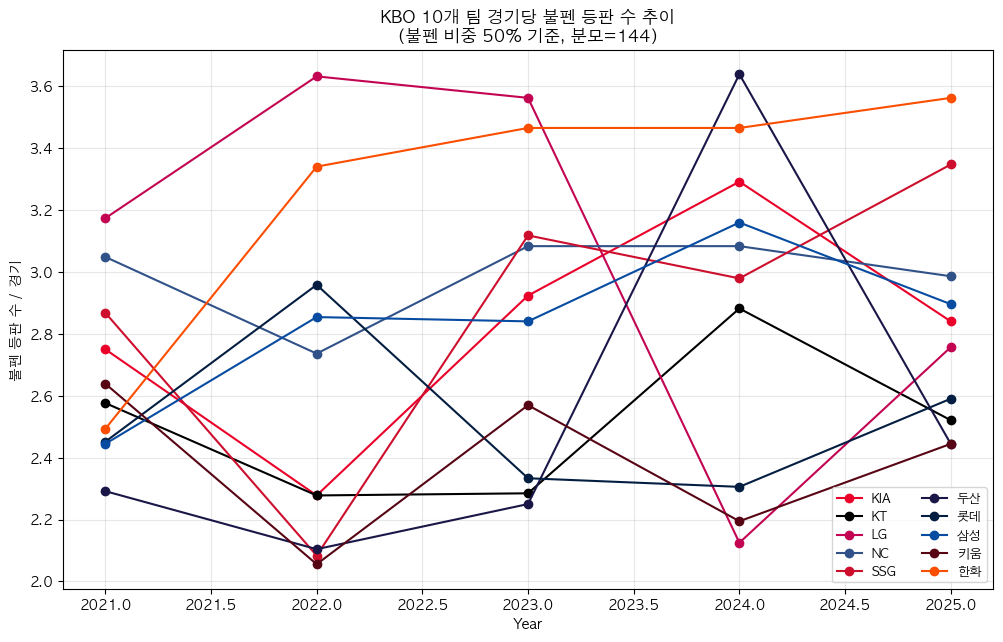

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 0) Load
# -------------------------------------------------------
PATH = "../data/processed/pitch_analysis_ip30_all_2021_2025.csv"
df = pd.read_csv(PATH)

YEARS = [2021, 2022, 2023, 2024, 2025]
TEAM_GAMES = {y: 144 for y in YEARS}

TEAM_COLORS = { 
    '한화': '#FC4E00', 
    'LG': '#C30452', 
    'KIA': '#EA0029', 
    'SSG': '#CE0E2D',
    '삼성':'#074CA1', 
    'NC':'#315288', 
    'KT':'#000000', 
    '롯데':'#041E42', 
    '두산':'#1A1748',
    '키움':'#570514'
}

# -------------------------------------------------------
# 1) 기본 필터
# -------------------------------------------------------
df = df.dropna(subset=["Year", "Team", "G", "GS"])
df = df[df["Year"].isin(YEARS) & (df["G"] > 0)].copy()

# -------------------------------------------------------
# 2) 불펜 정의 (50% 기준)
# -------------------------------------------------------
df["BP_G"] = df["G"] - df["GS"]
df_bp = df[df["BP_G"] > df["GS"]].copy()

# -------------------------------------------------------
# 3) 팀-연도별 불펜 등판 수
# -------------------------------------------------------
team_year = (
    df_bp
    .groupby(["Year", "Team"], as_index=False)
    .agg(bullpen_appearances=("BP_G", "sum"))
)

# -------------------------------------------------------
# 4) 경기당 불펜 등판 수
# -------------------------------------------------------
team_year["games"] = team_year["Year"].map(TEAM_GAMES)
team_year["bp_per_game"] = team_year["bullpen_appearances"] / team_year["games"]

# -------------------------------------------------------
# 5) 피벗 (Year x Team)
# -------------------------------------------------------
pivot_df = team_year.pivot(index="Year", columns="Team", values="bp_per_game")

print("\n[10개 팀 – 경기당 불펜 등판 수 (불펜 비중 50% 기준)]")
print(pivot_df.round(2))

# -------------------------------------------------------
# 6) 시각화 (10개 팀 전체)
# -------------------------------------------------------
plt.figure(figsize=(12, 7))

for team in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[team],
        marker="o",
        label=team,
        color=TEAM_COLORS.get(team, "#888888")
    )

plt.title(
    "KBO 10개 팀 경기당 불펜 등판 수 추이\n"
    "(불펜 비중 50% 기준, 분모=144)"
)
plt.xlabel("Year")
plt.ylabel("불펜 등판 수 / 경기")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.show()
